In [1]:
import CSV
import TypedTables: Table, columnnames

Load the isochrone table using `CSV.read` into a `TypedTables.Table` structure. This contains an isochrone table from PARSEC that has 26 steps in [M/H] and 71 steps in `logAge=log10(age [yr])` for a total of 1846 unique isochrones.

In [2]:
table = CSV.read("../../../../Work/Resources/isochrones/parsec/jwst/nircam_nov22/table.dat", Table; comment="#", delim=' ', ignorerepeated=true, 
    header=["Zini", "MH", "logAge", "Mini", "int_IMF", "Mass", "logL", "logTe", "logg", "label", "McoreTP", "C_O", "period0", "period1", "period2", 
        "period3", "period4", "pmode", "Mloss", "tau1m", "X",  "Y", "Xc",  "Xn",  "Xo",  "Cexcess",  "Z", "mbolmag",  "F070W",  "F090W",  "F115W",  
        "F150W",  "F200W",  "F277W",  "F356W",  "F444W",  "F150W2",  "F322W2",  "F140M",  "F162M",  "F182M",  "F210M",  "F250M",  "F300M",  "F335M",  
        "F360M",  "F410M",  "F430M",  "F460M",  "F480M"])

Table with 50 columns and 709192 rows:
      Zini       MH        logAge  Mini      int_IMF  Mass   logL    logTe   ⋯
    ┌─────────────────────────────────────────────────────────────────────────
 1  │ 2.4652e-5  -2.19174  6.6     0.1       1.17111  0.1    -1.436  3.5769  ⋯
 2  │ 2.4652e-5  -2.19174  6.6     0.105145  1.2127   0.105  -1.411  3.5791  ⋯
 3  │ 2.4652e-5  -2.19174  6.6     0.109821  1.24828  0.109  -1.387  3.5809  ⋯
 4  │ 2.4652e-5  -2.19174  6.6     0.124     1.34512  0.124  -1.321  3.5865  ⋯
 5  │ 2.4652e-5  -2.19174  6.6     0.129464  1.37867  0.129  -1.298  3.5885  ⋯
 6  │ 2.4652e-5  -2.19174  6.6     0.140418  1.4407   0.14   -1.252  3.5923  ⋯
 7  │ 2.4652e-5  -2.19174  6.6     0.149107  1.4856   0.149  -1.219  3.595   ⋯
 8  │ 2.4652e-5  -2.19174  6.6     0.183261  1.63379  0.182  -1.1    3.6048  ⋯
 9  │ 2.4652e-5  -2.19174  6.6     0.197245  1.68445  0.196  -1.057  3.6085  ⋯
 10 │ 2.4652e-5  -2.19174  6.6     0.207292  1.71805  0.206  -1.029  3.6111  ⋯
 11 │ 2.4652e

Check the available columns in the table

In [3]:
columnnames(table)

(:Zini, :MH, :logAge, :Mini, :int_IMF, :Mass, :logL, :logTe, :logg, :label, :McoreTP, :C_O, :period0, :period1, :period2, :period3, :period4, :pmode, :Mloss, :tau1m, :X, :Y, :Xc, :Xn, :Xo, :Cexcess, :Z, :mbolmag, :F070W, :F090W, :F115W, :F150W, :F200W, :F277W, :F356W, :F444W, :F150W2, :F322W2, :F140M, :F162M, :F182M, :F210M, :F250M, :F300M, :F335M, :F360M, :F410M, :F430M, :F460M, :F480M)

In [4]:
unique(table.MH) # These are metallicities, [M/H]

26-element Vector{Float64}:
 -2.19174
 -2.1
 -2.0
 -1.9
 -1.8
 -1.7
 -1.6
 -1.5
 -1.4
 -1.3
 -1.2
 -1.1
 -1.0
 -0.9
 -0.8
 -0.7
 -0.6
 -0.5
 -0.4
 -0.3
 -0.2
 -0.1
  0.0
  0.1
  0.2
  0.3

In [5]:
unique(table.logAge) # These are `log10(age)`, where the age is in years.

71-element Vector{Float64}:
  6.6
  6.65
  6.7
  6.75
  6.8
  6.85
  6.9
  6.95
  7.0
  7.05
  7.1
  7.15
  7.2
  ⋮
  9.55001
  9.60001
  9.65001
  9.70001
  9.75001
  9.80001
  9.85001
  9.90001
  9.95001
 10.00001
 10.05001
 10.10001

We'll construct a model Hess diagram from the populations in this isochrone table. First we need to set up our observational models for photometric error and incompleteness. You would typically measure these from artificial star tests but we'll make up some models here using functions built into StarFormationHistories.jl.

In [6]:
import StarFormationHistories: Martin2016_complete, exp_photerr

[ Info: Precompiling StarFormationHistories [774d3ad4-2d55-48fa-ab42-467705ebff24]


In [7]:
distmod = 25.0 # Distance modulus 
F090W_complete(m) = Martin2016_complete(m,1.0,28.5,0.7)
F150W_complete(m) = Martin2016_complete(m,1.0,27.5,0.7)
F090W_error(m) = min( exp_photerr(m, 1.03, 15.0, 36.0, 0.02), 0.4 )
F150W_error(m) = min( exp_photerr(m, 1.03, 15.0, 35.0, 0.02), 0.4 )

F150W_error (generic function with 1 method)

We'll make a few plots showing the adopted models. Below we set up PyPlot.jl (a wrapper for Python's matplotlib package).

In [8]:
import PyPlot as plt
import PyPlot: @L_str # For LatexStrings
import PyCall: @pyimport
plt.rc("text", usetex=true)
plt.rc("font", family="serif", serif=["Computer Modern"], size=14)
plt.rc("figure", figsize=(5,5))
plt.rc("patch", linewidth=1, edgecolor="k", force_edgecolor=true) 

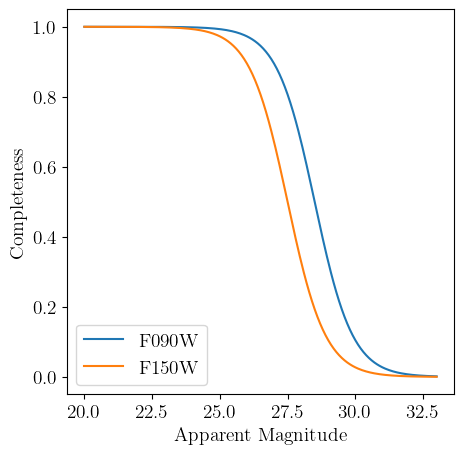

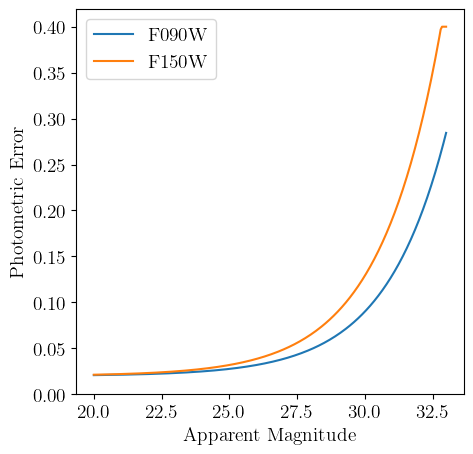

(0.0, 0.41895850114873723)

In [9]:
plotmags=20.0:0.05:33.0

fig,ax1=plt.subplots()
ax1.plot(plotmags,F090W_complete.(plotmags),label="F090W")
ax1.plot(plotmags,F150W_complete.(plotmags),label="F150W")
ax1.set_xlabel("Apparent Magnitude")
ax1.set_ylabel("Completeness")
ax1.legend(loc="lower left")

plotmags=20.0:0.05:33.0
fig,ax1=plt.subplots()
ax1.plot(plotmags,F090W_error.(plotmags),label="F090W")
ax1.plot(plotmags,F150W_error.(plotmags),label="F150W")
ax1.set_xlabel("Apparent Magnitude")
ax1.set_ylabel("Photometric Error")
ax1.legend(loc="upper left")
ax1.set_ylim([0.0,ax1.get_ylim()[2]])

We put a maximum on the magnitude error in the model because most of the time one would place a cut on the photometric catalog in either signal to noise (e.g., SNR>5) or magnitude error (e.g., error < 0.4). From a practical perspective, if we allow the photometric error model to grow too large, it will hurt the efficiency of `partial_cmd_smooth` for template creation later.

We may now define our mock star formation history. We will use `partial_cmd_smooth` to construct the templates for a Hess diagram model with F150W on the y-axis and F090W-F150W on the x-axis, with an initial mass function model from InitialMassFunctions.jl. We'll construct all 1846 templates, one for every isochrone in our table, but this may not always be necessary.

In [10]:
import StarFormationHistories: partial_cmd_smooth
import InitialMassFunctions: Kroupa2001

[ Info: Precompiling InitialMassFunctions [e9251ff4-c148-4db3-bf46-89407750fae0]


In [11]:
# Some additional setup
imf = Kroupa2001(0.08, 100.0) # Initial mass function model
unique_logAge = unique(table.logAge)
unique_MH = unique(table.MH)
template_norm = 1e3 # The stellar mass of the populations in each template
edges = (range(-0.5, 1.6, length=100), range(17.0, 28.0, length=100)) # The bin edges for the Hess diagrams

(-0.5:0.021212121212121213:1.6, 17.0:0.1111111111111111:28.0)

In [12]:
# Constructing the templates
templates = Vector{Matrix{Float64}}(undef,0)
template_logAge = Vector{Float64}(undef,0)
template_MH = Vector{Float64}(undef,0)
for logage in unique_logAge 
    for mh in unique_MH
        # Combination of a logage and an MH defines a unique isochrone.
        # Pick out all entries in `table` that match this combination; these will be row indices
        # into the table of the stars in this specific isochrone.
        local good = findall( (table.MH .== mh) .& (table.logAge .== logage) )
        # Chop off the last entry in the isochrone because its the 30 mag weird thing that parsec does.
        local m_ini = table.Mini[good][begin:end-1] # These are the initial masses of the stars in the isochrone, in solar masses.
        local iso_mags = [table.F090W[good][begin:end-1], table.F150W[good][begin:end-1]] # These are the absolute magnitudes we want from the isochrone.
        push!(templates, partial_cmd_smooth( m_ini, iso_mags, [F090W_error, F150W_error], 2, [1,2], imf, [F090W_complete, F150W_complete]; 
                dmod=distmod, normalize_value=template_norm, edges=edges).weights )
        push!(template_logAge, logage)
        push!(template_MH, mh)
    end
end

In [13]:
# Sort the template_logAge and template_MH so we have a guarantee for later
permidx = sortperm(template_logAge)
template_logAge = template_logAge[permidx]
template_MH = template_MH[permidx]
templates = templates[permidx]

1846-element Vector{Matrix{Float64}}:
 [0.0 5.308707755624576e-10 … 0.0 0.0; 6.906811253133398e-14 1.5108610725823887e-8 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 

We'll plot a few templates for reference.

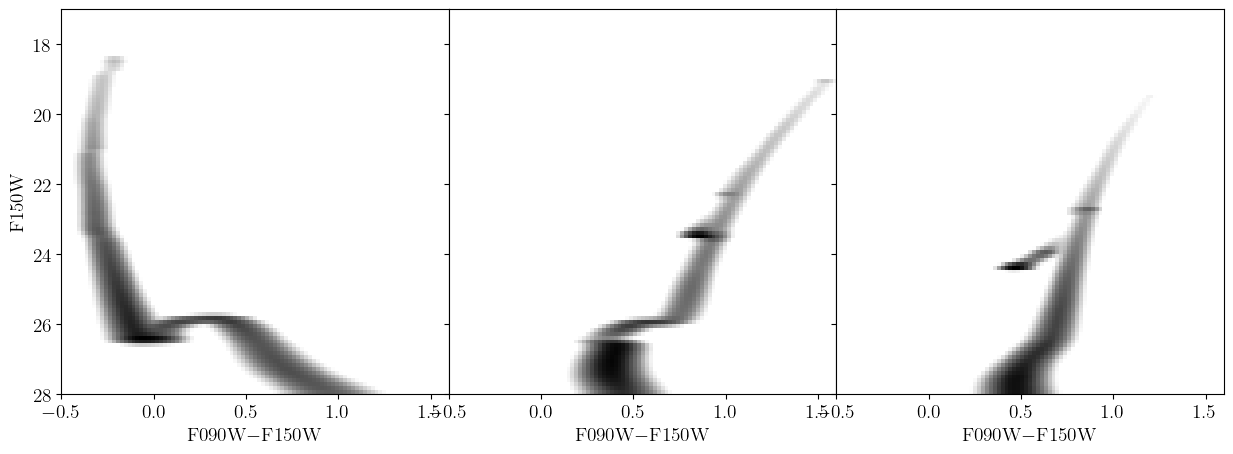

(-0.5, 1.6)

In [14]:
fig,axs=plt.subplots(1,3,sharey=true,figsize=(15,5))
fig.subplots_adjust(hspace=0.0,wspace=0.0)

axs[1].imshow(templates[100]', origin="lower", 
    extent=(extrema(edges[1])..., extrema(edges[2])...), 
    aspect="auto", cmap="Greys", norm=plt.matplotlib.colors.LogNorm(vmin=0.0005), rasterized=true) 
axs[2].imshow(templates[1500]', origin="lower", 
    extent=(extrema(edges[1])..., extrema(edges[2])...), 
    aspect="auto", cmap="Greys", norm=plt.matplotlib.colors.LogNorm(vmin=0.0005), rasterized=true) 
axs[3].imshow(templates[1800]', origin="lower", 
    extent=(extrema(edges[1])..., extrema(edges[2])...), 
    aspect="auto", cmap="Greys", norm=plt.matplotlib.colors.LogNorm(vmin=0.0005), rasterized=true) 
# im1.set_clim( [0.5, im1.get_clim()[2]] )
axs[1].set_xlabel(L"F090W$-$F150W")
axs[2].set_xlabel(L"F090W$-$F150W")
axs[3].set_xlabel(L"F090W$-$F150W")
axs[1].set_ylabel("F150W")
axs[1].set_ylim(reverse(extrema(edges[2]))) 
axs[1].set_xlim(extrema(edges[1]))

We may now use `construct_x0_mdf` and `calculate_coeffs_mdf` to create a mock star formation history with constant star formation rate and a reasonable metallicity evolution for a dwarf galaxy. 

In [15]:
import StarFormationHistories: construct_x0_mdf, calculate_coeffs_mdf

In [41]:
# Set overall stellar mass of complex population and the metallicity evolution variables
stellar_mass = 1e7
α, β, σ = -0.1, -0.5, 0.3
# We have to divide `stellar_mass` by `template_norm` here because `template_norm` is the total amount of stellar mass in each template, since we passed `normalize_value=template_norm` 
# when constructing the templates with `partial_cmd_smooth`. As such, when computing coefficients, we need to normalize out the adopted `normalize_value` for the templates.
x0_mdf = construct_x0_mdf(template_logAge; normalize_value=stellar_mass / template_norm)

71-element Vector{Float64}:
    3.1632043225667794
    0.38596939903202293
    0.4330647885097611
    0.4859066846163288
    0.5451962672082045
    0.6117202730241489
    0.6863614352037445
    0.7701101966197678
    0.8640778524534942
    0.9695112964064287
    1.0878095662222338
    1.220542408067581
    1.3694711061099618
    ⋮
  306.5934508845192
  344.0035098605409
  385.97828640818756
  433.0747603098365
  485.91787316001796
  545.2088209607206
  611.7343585661209
  686.3772394417871
  770.1279292665228
  864.0977488103649
  969.533620486047
 1087.8346142515018

The above coefficients are the amount of stellar mass formed in each age bin of `unique(template_logAge)`. To construct the complex Hess diagram, we need individual per-template weights, which we can get with `calculate_coeffs_mdf`.

In [42]:
x0 = calculate_coeffs_mdf(x0_mdf, template_logAge, template_MH, α, β, σ)

1846-element Vector{Float64}:
 5.2829726543486186e-8
 2.826921183569167e-7
 1.5815145856142794e-6
 7.917312015023231e-6
 3.5467238629346465e-5
 0.00014217461175929075
 0.0005099901434393602
 0.0016369920555552111
 0.004701932806375619
 0.012085129897158828
 0.027795294805119823
 0.05720530481915483
 0.10535287243213265
 ⋮
 0.9184532583057752
 0.29935512265025405
 0.08730947705594681
 0.02278668439692459
 0.005321645552722102
 0.001112130651303691
 0.0002079748086561259
 3.480252177916151e-5
 5.211416120029412e-6
 6.983061190509914e-7
 8.372998258276432e-8
 8.983823513353381e-9

Let's plot the cumulative SFH and mean [M/H] of our model population.

In [45]:
import StarFormationHistories: calculate_cum_sfr
unique_template_logAge, cum_sfr_arr, sfr_arr, mean_mh_arr = calculate_cum_sfr(x0, template_logAge, template_MH; normalize_value=template_norm)

([6.6, 6.65, 6.7, 6.75, 6.8, 6.85, 6.9, 6.95, 7.0, 7.05  …  9.65001, 9.70001, 9.75001, 9.80001, 9.85001, 9.90001, 9.95001, 10.00001, 10.05001, 10.10001], [0.9999999999999997, 0.9996837795947182, 0.9996451948599551, 0.9996019020754964, 0.9995533267723956, 0.9994988243858933, 0.9994376717024342, 0.999369057263063, 0.9992920705958569, 0.9992056901345163  …  0.6837722340374748, 0.6451866108176718, 0.6018928294943103, 0.553316407892987, 0.49881276641234773, 0.4376586748444147, 0.3690426555491192, 0.29205421563905803, 0.20567176529205472, 0.1087490618748904], [0.0007945610017947954, 0.0007945612013795453, 0.0007945612013795453, 0.0007945612013795455, 0.0007945612013795449, 0.0007945612013795455, 0.0007945612013795454, 0.0007945612013795451, 0.0007945612013795454, 0.0007945612013795456  …  0.0007945612013795454, 0.0007945612013795456, 0.0007945612013795455, 0.0007945612013795456, 0.0007945612013795453, 0.0007945612013795451, 0.0007945612013795453, 0.0007945612013795456, 0.0007945612013795455,

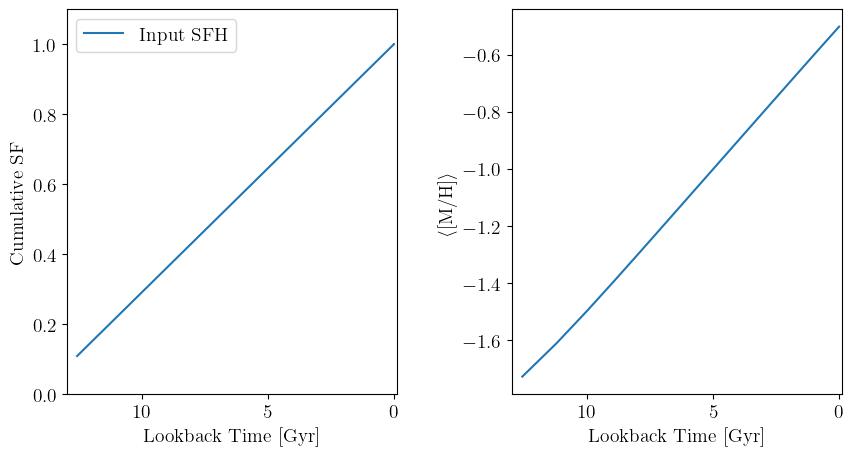

PyObject Text(457.3650849792141, 0.5, '$\\langle$[M/H]$\\rangle$')

In [46]:
fig,axs=plt.subplots(nrows=1,ncols=2,sharex=true,sharey=false,figsize=(10,5))
fig.subplots_adjust(hspace=0.0,wspace=0.35)

axs[1].plot( exp10.(unique_template_logAge)./1e9, cum_sfr_arr, label="Input SFH" )

axs[1].set_xlim([13.0,-0.1])
axs[1].set_ylim([0.0,1.1])
axs[1].set_xlabel("Lookback Time [Gyr]")
axs[1].set_ylabel("Cumulative SF")
axs[1].legend()

axs[2].plot( exp10.(unique_template_logAge)./1e9, mean_mh_arr, label="Input SFH" )
axs[2].set_xlabel("Lookback Time [Gyr]")
axs[2].set_ylabel(L"$\langle$[M/H]$\rangle$")

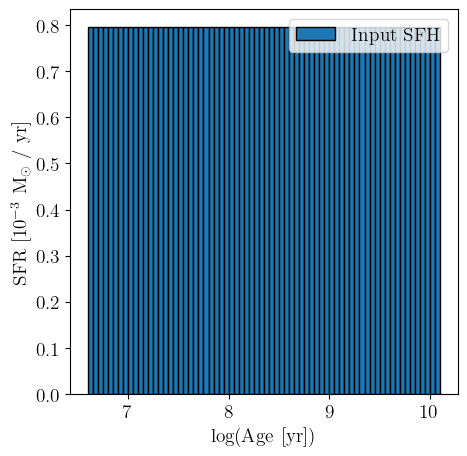

PyObject <matplotlib.legend.Legend object at 0x7fa045186d70>

In [47]:
fig,ax1 = plt.subplots()
ax1.bar(unique_template_logAge[begin:end-1], sfr_arr[begin:end-1] .* 1e3; width=diff(unique_template_logAge), align="edge", label="Input SFH")
ax1.set_xlabel("log(Age [yr])")
ax1.set_ylabel(L"SFR [$10^{-3}$ M$_\odot$ / yr]")
ax1.set_ylim([0.0, ax1.get_ylim()[2]])
ax1.legend()

Now let's make a model Hess diagram with this SFH. We can simply write `composite = sum( coeffs .* models)` if we want, but we also provide the `composite!` function that is more efficient.

In [77]:
import BenchmarkTools: @btime
@btime model1 = sum( x0 .* templates)

  26.830 ms (7386 allocations: 276.38 MiB)


99×99 Matrix{Float64}:
 0.0          2.80458e-17  6.82329e-16  …  0.0          0.0
 3.64885e-21  7.98184e-16  1.67736e-14     0.0          0.0
 8.63848e-19  1.37904e-14  2.43507e-13     1.55169e-20  0.0
 4.04661e-17  1.49166e-13  2.09544e-12     1.13733e-14  2.57145e-17
 1.44039e-15  1.07941e-12  1.07478e-11     6.14054e-11  5.83515e-13
 9.5321e-12   4.8643e-11   5.11416e-11  …  5.54255e-9   7.76611e-11
 9.58498e-10  6.00513e-9   2.46369e-8      9.77816e-8   2.40016e-9
 4.26846e-8   1.85007e-7   6.73909e-7      7.9791e-7    3.21385e-8
 9.23827e-7   3.42256e-6   1.09591e-5      4.35873e-6   2.45304e-7
 1.24642e-5   3.91084e-5   0.000107173     1.88969e-5   1.29223e-6
 0.000104134  0.000274419  0.000635197  …  7.10267e-5   5.47169e-6
 0.000539639  0.00118578   0.00230891      0.000239762  1.9947e-5
 0.00175648   0.00319153   0.00524382      0.000745471  6.59014e-5
 ⋮                                      ⋱               
 0.0343291    0.0396613    0.0395587       0.000613508  0.000973286


In [78]:
model2 = similar(model1)
import StarFormationHistories: composite!
@btime composite!(model2, x0, templates)
model2

  6.094 ms (0 allocations: 0 bytes)


99×99 Matrix{Float64}:
 0.0          2.80458e-17  6.82329e-16  …  0.0          0.0
 3.64885e-21  7.98184e-16  1.67736e-14     0.0          0.0
 8.63848e-19  1.37904e-14  2.43507e-13     1.55169e-20  0.0
 4.04661e-17  1.49166e-13  2.09544e-12     1.13733e-14  2.57145e-17
 1.44039e-15  1.07941e-12  1.07478e-11     6.14054e-11  5.83515e-13
 9.5321e-12   4.8643e-11   5.11416e-11  …  5.54255e-9   7.76611e-11
 9.58498e-10  6.00513e-9   2.46369e-8      9.77816e-8   2.40016e-9
 4.26846e-8   1.85007e-7   6.73909e-7      7.9791e-7    3.21385e-8
 9.23827e-7   3.42256e-6   1.09591e-5      4.35873e-6   2.45304e-7
 1.24642e-5   3.91084e-5   0.000107173     1.88969e-5   1.29223e-6
 0.000104134  0.000274419  0.000635197  …  7.10267e-5   5.47169e-6
 0.000539639  0.00118578   0.00230891      0.000239762  1.9947e-5
 0.00175648   0.00319153   0.00524382      0.000745471  6.59014e-5
 ⋮                                      ⋱               
 0.0343291    0.0396613    0.0395587       0.000613508  0.000973286


In [79]:
model1 ≈ model2

true

Let's plot the smooth model.

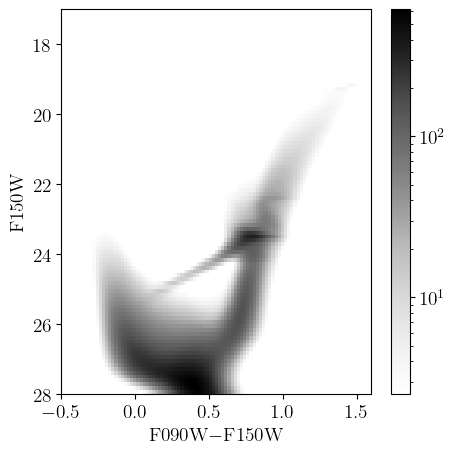

PyObject <matplotlib.colorbar.Colorbar object at 0x7fa0383249d0>

In [86]:
fig,ax1=plt.subplots()

im1=ax1.imshow(model2', origin="lower", 
    extent=(extrema(edges[1])..., extrema(edges[2])...), 
    aspect="auto", cmap="Greys", norm=plt.matplotlib.colors.LogNorm(vmin=2.5), rasterized=true) 
ax1.set_xlabel(L"F090W$-$F150W")
ax1.set_ylabel("F150W")
ax1.set_ylim(reverse(extrema(edges[2]))) 
ax1.set_xlim(extrema(edges[1]))
fig.colorbar(im1)

The templates are constructed such that the 2D histogram pixel values give the expected number of stars in that bin for a population with total stellar mass `normalize_value` (in our case we defined the variable `template_norm=1e3` and used that as our `normalize_value` for the templates). As such the pixel values of this complex model also represent expected numbers of stars per bin for our defined SFH. We may, therefore, simply Poisson sample it to obtain an observational realization of the Hess diagram:

In [88]:
import Distributions: Poisson
import Random: AbstractRNG, default_rng
function poisson_sample!(sample::T, model::S, rng::AbstractRNG=default_rng()) where {T <: AbstractArray{<:Number}, S <: AbstractArray{<:Number}}
    @assert axes(sample) == axes(model)
    for i in eachindex(sample, model)
        sample[i] = rand(rng,Poisson(model[i]))
    end
end
poisson_sample(model::AbstractArray{<:Number}, rng::AbstractRNG=default_rng()) = (sample = similar(model); poisson_sample!(sample, model, rng); return sample)
model3 = poisson_sample(model2)

99×99 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

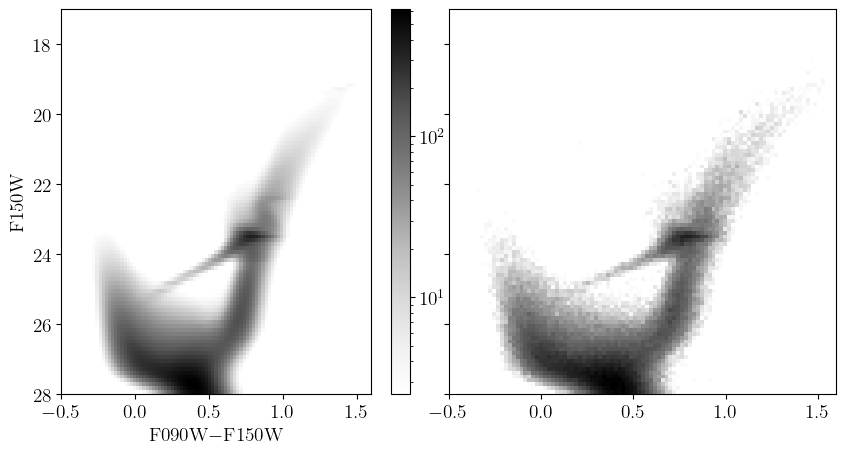

PyObject <matplotlib.colorbar.Colorbar object at 0x7fa0299d7cd0>

In [97]:
fig,axs=plt.subplots(nrows=1,ncols=2,sharex=true,sharey=true,figsize=(10,5))
fig.subplots_adjust(hspace=0.0,wspace=0.0)

im1=axs[1].imshow(model2', origin="lower", 
    extent=(extrema(edges[1])..., extrema(edges[2])...), 
    aspect="auto", cmap="Greys", norm=plt.matplotlib.colors.LogNorm(vmin=2.5), rasterized=true) 
axs[2].imshow(model3', origin="lower", 
    extent=(extrema(edges[1])..., extrema(edges[2])...), 
    aspect="auto", cmap="Greys", norm=plt.matplotlib.colors.LogNorm(vmin=2.5,vmax=im1.get_clim()[2]), rasterized=true) 
axs[1].set_xlabel(L"F090W$-$F150W")
axs[1].set_ylabel("F150W")
axs[1].set_ylim(reverse(extrema(edges[2]))) 
axs[1].set_xlim(extrema(edges[1]))
fig.colorbar(im1)